In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression

from sklearn import metrics, svm
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

import xgboost as xgb

from catboost import CatBoostClassifier, Pool

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


In [2]:
data = pd.read_csv("/home/andrija/Desktop/customer_complaints/notebooks/processed_data_label.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)

## Further Feature Engineering

In [3]:
data.drop(columns=['Company public response', 'Timely response?', 'Tags', 'Consumer complaint narrative',
                   'Day sent to company', 'Sub-issue'], inplace=True)

## Predictor Separation

In [4]:
y = data['Consumer disputed?'].copy()
X = data.drop(['Consumer disputed?'], axis=1).copy()

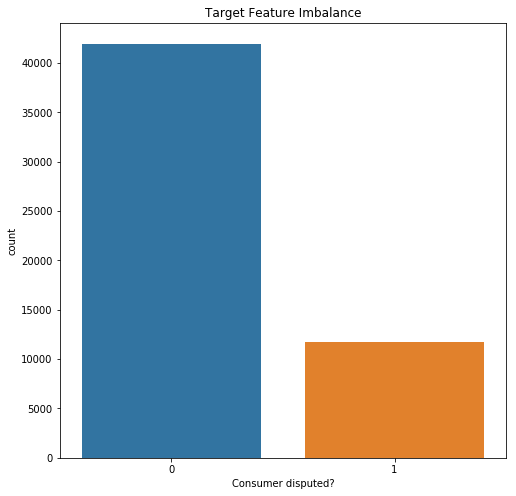

In [5]:
plt.figure(figsize=(8, 8))
sns.countplot('Consumer disputed?', data=data)
plt.title('Target Feature Imbalance')
plt.show()

## Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y)

## Imbalance of Target Feature

### Undersampling 'Consumer disputed?' 

In [7]:
# data_train = pd.concat([X_train, y_train], axis=1)

# data_shuffled = data_train.sample(frac=1, random_state=4)
# disputed = data_shuffled.loc[data_shuffled['Consumer disputed?'] == 1]

# non_disputed = data_shuffled.loc[data_shuffled['Consumer disputed?'] == 0].sample(n=disputed.shape[0],random_state=42)
# balanced_data = pd.concat([disputed, non_disputed])

# X_train = balanced_data.drop(['Consumer disputed?'], axis=1)
# y_train = balanced_data['Consumer disputed?'].copy()

### SMOTE Oversampling

In [6]:
os = SMOTE(random_state=42)

columns = X_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X, columns=columns )
os_data_y= pd.DataFrame(data=os_data_y, columns=['Consumer disputed?'])

balanced_data = pd.concat([os_data_X, os_data_y], sort=False)

os_data_y.sum()

Consumer disputed?    29384
dtype: int64

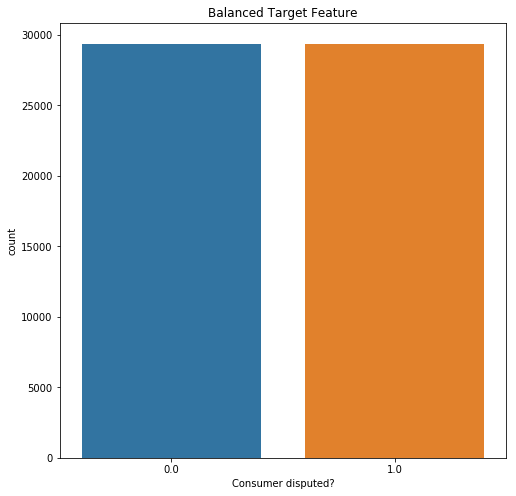

In [9]:
plt.figure(figsize=(8, 8))
sns.countplot('Consumer disputed?', data=balanced_data)
plt.title('Balanced Target Feature')
plt.show()

### Train Data

In [7]:
X_train = os_data_X
y_train = np.array(os_data_y).ravel()

## Logistig Regression

In [246]:
log = LogisticRegression(C=0.05, random_state=43, solver='lbfgs', max_iter=1000)

In [247]:
log.fit(X_train, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=43, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [248]:
y_pred = log.predict(X_test)

In [249]:
log.score(X_test, y_test)

0.5212316861186987

In [250]:
roc_auc_score(y_test, y_pred)

0.5102463277765347

In [251]:
confusion = confusion_matrix(y_test, y_pred)

In [252]:
confusion

array([[6671, 5922],
       [1790, 1725]])

In [253]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.53      0.63     12593
           1       0.23      0.49      0.31      3515

    accuracy                           0.52     16108
   macro avg       0.51      0.51      0.47     16108
weighted avg       0.67      0.52      0.56     16108



## XGBoost

In [8]:
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, subsample=0.8, max_depth=5, random_state=42)

In [9]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [10]:
y_pred = xgb_model.predict(X_test)

In [11]:
confusion_matrix(y_test, y_pred)

array([[7358, 5235],
       [1756, 1759]])

In [12]:
accuracy_score(y_test, y_pred)

0.5659920536379439

In [13]:
roc_auc_score(y_test, y_pred)

0.5423598018226613

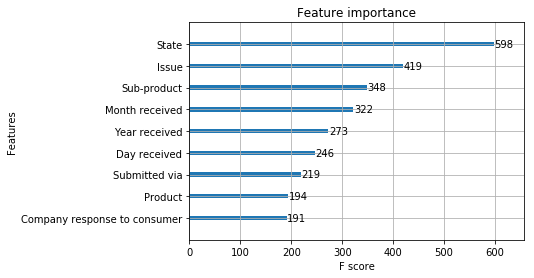

In [14]:
xgb.plot_importance(xgb_model)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.58      0.68     12593
           1       0.25      0.50      0.33      3515

    accuracy                           0.57     16108
   macro avg       0.53      0.54      0.51     16108
weighted avg       0.69      0.57      0.60     16108



## SVM

In [48]:
svc = svm.SVC(C=0.025, kernel='rbf', gamma='auto', probability=True)

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

accuracy_score(y_test, y_pred)

0.4349566998789459

## CatBoost

In [206]:
model = CatBoostClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

Learning rate set to 0.055106
0:	learn: 0.6767893	total: 71ms	remaining: 1m 10s
1:	learn: 0.6684233	total: 91.3ms	remaining: 45.6s
2:	learn: 0.6572256	total: 111ms	remaining: 37s
3:	learn: 0.6433201	total: 129ms	remaining: 32.2s
4:	learn: 0.6351820	total: 142ms	remaining: 28.3s
5:	learn: 0.6267125	total: 155ms	remaining: 25.7s
6:	learn: 0.6227038	total: 168ms	remaining: 23.9s
7:	learn: 0.6127581	total: 181ms	remaining: 22.5s
8:	learn: 0.6066760	total: 218ms	remaining: 24s
9:	learn: 0.5987279	total: 242ms	remaining: 24s
10:	learn: 0.5940096	total: 262ms	remaining: 23.6s
11:	learn: 0.5911260	total: 280ms	remaining: 23.1s
12:	learn: 0.5863356	total: 294ms	remaining: 22.3s
13:	learn: 0.5825363	total: 307ms	remaining: 21.6s
14:	learn: 0.5803883	total: 319ms	remaining: 21s
15:	learn: 0.5758507	total: 332ms	remaining: 20.4s
16:	learn: 0.5726222	total: 345ms	remaining: 20s
17:	learn: 0.5658902	total: 358ms	remaining: 19.5s
18:	learn: 0.5631461	total: 369ms	remaining: 19.1s
19:	learn: 0.5543924

167:	learn: 0.4063435	total: 2.57s	remaining: 12.7s
168:	learn: 0.4062801	total: 2.6s	remaining: 12.8s
169:	learn: 0.4057954	total: 2.61s	remaining: 12.8s
170:	learn: 0.4053543	total: 2.63s	remaining: 12.7s
171:	learn: 0.4045379	total: 2.64s	remaining: 12.7s
172:	learn: 0.4043582	total: 2.65s	remaining: 12.7s
173:	learn: 0.4042885	total: 2.67s	remaining: 12.7s
174:	learn: 0.4041669	total: 2.68s	remaining: 12.6s
175:	learn: 0.4039032	total: 2.69s	remaining: 12.6s
176:	learn: 0.4036186	total: 2.71s	remaining: 12.6s
177:	learn: 0.4035545	total: 2.72s	remaining: 12.6s
178:	learn: 0.4029589	total: 2.73s	remaining: 12.5s
179:	learn: 0.4028238	total: 2.75s	remaining: 12.5s
180:	learn: 0.4026896	total: 2.76s	remaining: 12.5s
181:	learn: 0.4025343	total: 2.77s	remaining: 12.5s
182:	learn: 0.4024440	total: 2.79s	remaining: 12.5s
183:	learn: 0.4021345	total: 2.81s	remaining: 12.5s
184:	learn: 0.4019221	total: 2.82s	remaining: 12.4s
185:	learn: 0.4014677	total: 2.83s	remaining: 12.4s
186:	learn: 0

335:	learn: 0.3668175	total: 4.91s	remaining: 9.71s
336:	learn: 0.3667642	total: 4.94s	remaining: 9.72s
337:	learn: 0.3667089	total: 4.96s	remaining: 9.71s
338:	learn: 0.3666120	total: 4.97s	remaining: 9.69s
339:	learn: 0.3662939	total: 4.98s	remaining: 9.67s
340:	learn: 0.3662440	total: 5s	remaining: 9.65s
341:	learn: 0.3661777	total: 5.01s	remaining: 9.64s
342:	learn: 0.3661129	total: 5.02s	remaining: 9.62s
343:	learn: 0.3659286	total: 5.04s	remaining: 9.6s
344:	learn: 0.3658877	total: 5.05s	remaining: 9.58s
345:	learn: 0.3658158	total: 5.06s	remaining: 9.57s
346:	learn: 0.3657838	total: 5.07s	remaining: 9.55s
347:	learn: 0.3657439	total: 5.09s	remaining: 9.53s
348:	learn: 0.3656890	total: 5.1s	remaining: 9.51s
349:	learn: 0.3656322	total: 5.12s	remaining: 9.5s
350:	learn: 0.3655462	total: 5.14s	remaining: 9.5s
351:	learn: 0.3655072	total: 5.15s	remaining: 9.49s
352:	learn: 0.3651258	total: 5.17s	remaining: 9.47s
353:	learn: 0.3650450	total: 5.18s	remaining: 9.45s
354:	learn: 0.36497

501:	learn: 0.3531029	total: 7.24s	remaining: 7.18s
502:	learn: 0.3530593	total: 7.26s	remaining: 7.17s
503:	learn: 0.3530231	total: 7.27s	remaining: 7.16s
504:	learn: 0.3529888	total: 7.29s	remaining: 7.14s
505:	learn: 0.3529426	total: 7.3s	remaining: 7.13s
506:	learn: 0.3528851	total: 7.31s	remaining: 7.11s
507:	learn: 0.3527846	total: 7.33s	remaining: 7.1s
508:	learn: 0.3527056	total: 7.34s	remaining: 7.08s
509:	learn: 0.3526574	total: 7.35s	remaining: 7.07s
510:	learn: 0.3526225	total: 7.37s	remaining: 7.05s
511:	learn: 0.3525861	total: 7.38s	remaining: 7.03s
512:	learn: 0.3525407	total: 7.39s	remaining: 7.02s
513:	learn: 0.3524962	total: 7.41s	remaining: 7s
514:	learn: 0.3524491	total: 7.42s	remaining: 6.99s
515:	learn: 0.3524117	total: 7.43s	remaining: 6.97s
516:	learn: 0.3523405	total: 7.46s	remaining: 6.96s
517:	learn: 0.3522830	total: 7.47s	remaining: 6.95s
518:	learn: 0.3522388	total: 7.48s	remaining: 6.93s
519:	learn: 0.3522050	total: 7.5s	remaining: 6.92s
520:	learn: 0.3521

664:	learn: 0.3450651	total: 9.54s	remaining: 4.81s
665:	learn: 0.3450357	total: 9.57s	remaining: 4.8s
666:	learn: 0.3450106	total: 9.59s	remaining: 4.79s
667:	learn: 0.3449674	total: 9.61s	remaining: 4.77s
668:	learn: 0.3449237	total: 9.62s	remaining: 4.76s
669:	learn: 0.3448796	total: 9.63s	remaining: 4.74s
670:	learn: 0.3448560	total: 9.64s	remaining: 4.73s
671:	learn: 0.3448141	total: 9.66s	remaining: 4.71s
672:	learn: 0.3447777	total: 9.67s	remaining: 4.7s
673:	learn: 0.3447507	total: 9.69s	remaining: 4.68s
674:	learn: 0.3447196	total: 9.7s	remaining: 4.67s
675:	learn: 0.3446834	total: 9.71s	remaining: 4.65s
676:	learn: 0.3446651	total: 9.72s	remaining: 4.64s
677:	learn: 0.3446455	total: 9.74s	remaining: 4.62s
678:	learn: 0.3446074	total: 9.76s	remaining: 4.62s
679:	learn: 0.3445756	total: 9.78s	remaining: 4.6s
680:	learn: 0.3445315	total: 9.8s	remaining: 4.59s
681:	learn: 0.3444948	total: 9.82s	remaining: 4.58s
682:	learn: 0.3444773	total: 9.84s	remaining: 4.57s
683:	learn: 0.344

834:	learn: 0.3386103	total: 12.1s	remaining: 2.38s
835:	learn: 0.3385776	total: 12.1s	remaining: 2.37s
836:	learn: 0.3385404	total: 12.1s	remaining: 2.36s
837:	learn: 0.3385068	total: 12.1s	remaining: 2.34s
838:	learn: 0.3384925	total: 12.1s	remaining: 2.33s
839:	learn: 0.3384403	total: 12.1s	remaining: 2.31s
840:	learn: 0.3384117	total: 12.2s	remaining: 2.3s
841:	learn: 0.3383743	total: 12.2s	remaining: 2.28s
842:	learn: 0.3383559	total: 12.2s	remaining: 2.27s
843:	learn: 0.3383322	total: 12.2s	remaining: 2.25s
844:	learn: 0.3383064	total: 12.2s	remaining: 2.24s
845:	learn: 0.3382804	total: 12.2s	remaining: 2.23s
846:	learn: 0.3382462	total: 12.2s	remaining: 2.21s
847:	learn: 0.3382172	total: 12.3s	remaining: 2.19s
848:	learn: 0.3381939	total: 12.3s	remaining: 2.18s
849:	learn: 0.3381684	total: 12.3s	remaining: 2.17s
850:	learn: 0.3381301	total: 12.3s	remaining: 2.15s
851:	learn: 0.3380718	total: 12.3s	remaining: 2.14s
852:	learn: 0.3380380	total: 12.3s	remaining: 2.13s
853:	learn: 0

997:	learn: 0.3331216	total: 14.4s	remaining: 28.8ms
998:	learn: 0.3330871	total: 14.4s	remaining: 14.4ms
999:	learn: 0.3330479	total: 14.4s	remaining: 0us


0.7798677716733402

## KNN

In [116]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

0.5702579383555266

## Decision Tree

In [75]:
dec_tree = DecisionTreeClassifier()

dec_tree.fit(X_train, y_train)

y_pred = dec_tree.predict(X_test)

accuracy_score(y_test, y_pred)

0.6629108855573145

## Random Forests

In [119]:
forest = RandomForestClassifier(n_estimators=10)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

accuracy_score(y_test, y_pred)

0.6637489524164261

## ROC Curve

### Logistic Regression

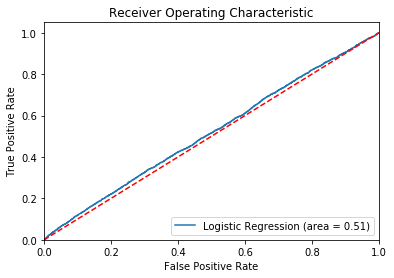

In [254]:
logit_roc_auc = roc_auc_score(y_test, log.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_attempt2')
plt.show()

### XGBoost

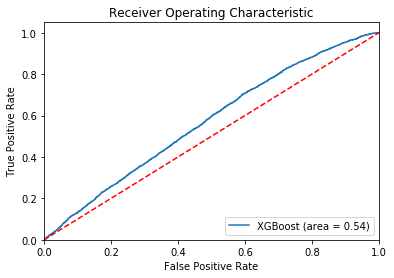

In [16]:
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC_attempt2')
plt.show()

### SVM

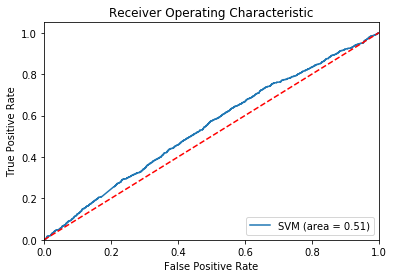

In [46]:
svm_roc_auc = roc_auc_score(y_test, svc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC_attempt1')
plt.show()

### CatBoost

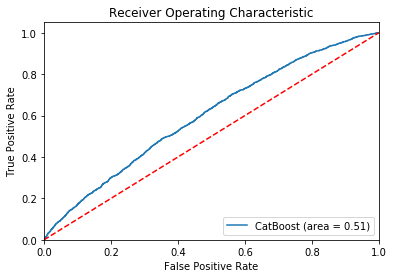

In [207]:
cb_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='CatBoost (area = %0.2f)' % cb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('CB_ROC_attempt1')
plt.show()

### KNN

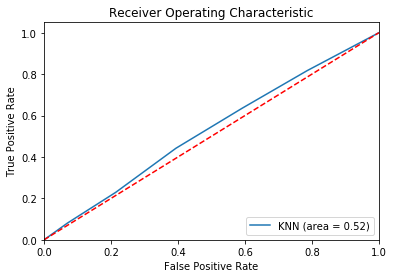

In [117]:
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC_attempt1')
plt.show()

### Decision Tree Classifier

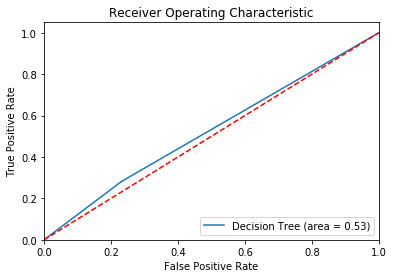

In [76]:
dec_tree_roc_auc = roc_auc_score(y_test, dec_tree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dec_tree.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dec_tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Decision_Tree_ROC_attempt1')
plt.show()

### Random Forests

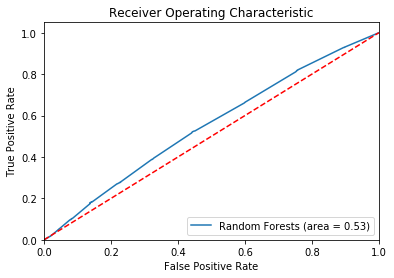

In [120]:
forest_roc_auc = roc_auc_score(y_test, forest.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forests (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Random_Forests_ROC_attempt1')
plt.show()